In [1]:
# External dependencies
import os
import shutil
import numpy as np
from nvtabular.ops import *
from merlin.schema.tags import Tags

import nvtabular as nvt

from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
df_lib = get_lib()

2024-06-18 08:40:21.721842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
INPUT_DATA_DIR = "book_dataset/"

In [3]:
books = df_lib.read_parquet(os.path.join(INPUT_DATA_DIR, "books_converted.parquet"))
books.head()

,ISBN,Book-Title
0,0195153448,Classical Mythology
1,0002005018,Clara Callan
2,0060973129,Decision in Normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic...
4,0393045218,The Mummies of Urumchi


Defining our Preprocessing Pipeline

In [4]:
CATEGORICAL_COLUMNS = ["User-ID", "ISBN"]
LABEL_COLUMNS = ["Book-Rating"]

In [5]:
userId = ["User-ID"] >> TagAsUserID()
isbn = ["ISBN"] >> TagAsItemID()

joined = userId + isbn >> JoinExternal(books, on=["ISBN"])

/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


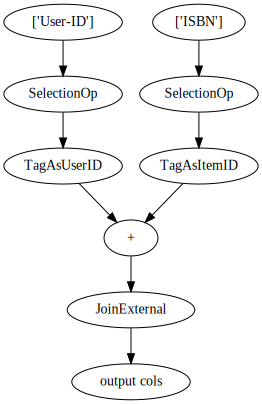

In [6]:
joined.graph

In [7]:
cat_features = joined >> Categorify()

In [8]:
ratings = nvt.ColumnGroup(["Book-Rating"]) >> LambdaOp(lambda col: (col > 6).astype("int8")) >> AddTags(Tags.TARGET)

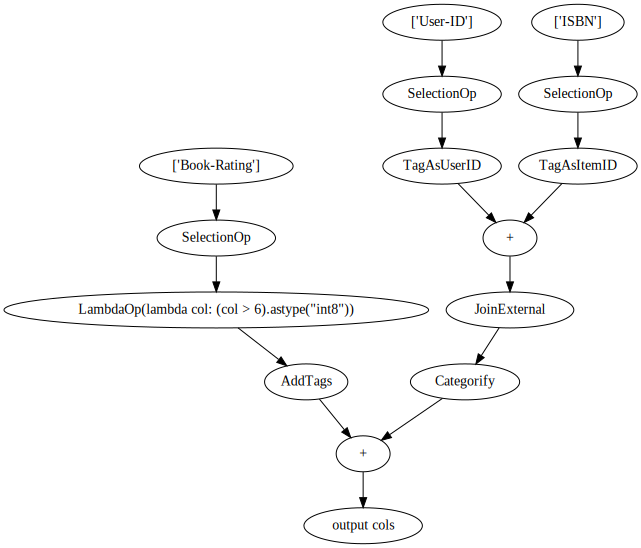

In [9]:
output = cat_features + ratings
(output).graph

In [10]:
# initialize NVTabular workflow.
workflow = nvt.Workflow(output)

Running the pipeline

In [11]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [12]:
train_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "train.parquet")])
valid_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "valid.parquet")])

/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [13]:
train_dataset.head()

,User-ID,ISBN,Book-Rating
0,120476,1573229326,6
1,26544,0373055056,0
2,102275,0440226023,0
3,258206,091581143X,0
4,62958,1582970033,0


In [14]:
%%time
workflow.fit(train_dataset)

/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/io/dataset.py:457: UserWarning: Changing an NVTabular Dataset to CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


CPU times: user 6.69 s, sys: 545 ms, total: 7.23 s
Wall time: 7.2 s


In [15]:
%time
workflow.transform(train_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "train"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=["User-ID", "ISBN"],
    labels=["Book-Rating"],
    dtypes=dict_dtypes,
    write_hugectr_keyset=True  # only needed if using this ETL Notebook for training with HugeCTR
                               # should be removed otherwise to speed up computation
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [16]:
%time
workflow.transform(valid_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "valid"),
    shuffle=False,
    cats=["User-ID", "ISBN"],
    labels=["Book-Rating"],
    dtypes=dict_dtypes,
    write_hugectr_keyset=True  # only needed if using this ETL Notebook for training with HugeCTR
                               # should be removed otherwise to speed up computation
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


/home/studio-lab-user/.conda/envs/merlin_env/lib/python3.8/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [17]:
workflow.save(os.path.join(INPUT_DATA_DIR, "workflow"))
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,User-ID,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,.//categories/unique.User-ID.parquet,0.0,92968.0,User-ID,92969.0,512.0
1,ISBN,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,.//categories/unique.ISBN.parquet,0.0,298686.0,ISBN,298687.0,512.0
2,Book-Title,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,.//categories/unique.Book-Title.parquet,0.0,213681.0,Book-Title,213682.0,512.0
3,Book-Rating,(Tags.TARGET),"DType(name='int8', element_type=<ElementType.I...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking the pre-processing outputs

In [18]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "valid", "*.parquet")))
TRAIN_PATHS, VALID_PATHS

(['book_dataset/train/part_0.parquet'], ['book_dataset/valid/part_0.parquet'])

In [19]:
df = df_lib.read_parquet(TRAIN_PATHS[0])
df.head()

,User-ID,ISBN,Book-Title,Book-Rating
0,36647,3,3,0.0
1,86289,3952,1,0.0
2,1663,13121,9234,1.0
3,334,1896,2146,0.0
4,5439,15669,14720,0.0
